### Data load and preprocess

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from datetime import datetime
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# suppress
import os
os.environ["PYTHONWARNINGS"] = "ignore"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

separator = '___________________________'

In [2]:
def mean_error(y_true, y_pred):
    return np.mean(y_true - y_pred)

mean_error_scorer = make_scorer(mean_error, greater_is_better=False)
mean_absolute_error_scorer = make_scorer(mean_absolute_error, greater_is_better=True)
mean_squared_error_scorer = make_scorer(mean_squared_error, greater_is_better=True)
r2_scorer = make_scorer(r2_score)

# nested cross validation
def get_best_params_reg(pipeline, params, X, y):
    
    grid = GridSearchCV(pipeline, param_grid=params, cv=KFold(n_splits=5, shuffle=True, random_state=7), 
                        scoring='neg_mean_squared_error', n_jobs=-1)

    cv = KFold(n_splits=5, shuffle=True, random_state=7)
    scoring = {
        'mean_error': mean_error_scorer,
        'mean_absolute_error': mean_absolute_error_scorer,
        'mean_squared_error': mean_squared_error_scorer,
        'r2': r2_scorer
    }
    
    scores = cross_validate(grid, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    
    grid.fit(X, y)
    best_params = grid.best_params_

    return scores, best_params 

def print_scores(scores):
    print(f'Mean error: {np.mean(scores["test_mean_error"])}')
    print(f'Mean absolute error: {np.mean(scores["test_mean_absolute_error"])}')
    print(f'Mean squared error: {np.mean(scores["test_mean_squared_error"])}')
    print(f'R2: {np.mean(scores["test_r2"])}')
    
    
def plot_stats(df, groups, results_dir):
    '''
    Plot correlation matrix.
    Plot correlation for each feature with target.
    Plot distribution for each feature per group.
    '''
    
    correlation_matrix = df.corr()
    plt.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Pearson Correlation Heatmap')
    plt.savefig(f'{results_dir}/corr_heatmap.png')
    plt.show()

    correlation = df.corr()[['target']].drop('target')
    plt.figure(figsize=(5, len(correlation) * 0.5 + 3))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'Pearson Correlation with Target feature')
    plt.savefig(f'{results_dir}/corr_target.png')
    plt.show()

    # Boxplots and T-test only for numeric features (skip binary)
    features = [col for col in df.columns if df[col].nunique() > 2]

    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.boxplot(x='group', y=feature, data=df, ax=axes[i])
        asa_group = df[df['group'] == groups[0]][feature]
        non_asa_group = df[df['group'] == groups[1]][feature]
        t_stat, p_value = stats.ttest_ind(asa_group, non_asa_group, equal_var=False)
        axes[i].set_title(f'{feature} (p={p_value:.3f})')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)


    # Hide unused subplots if features are less than available grid slots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f'{results_dir}/boxplots.png')
    plt.show()
    
def calculate_shift(y_true, y_pred, results_dir='./results', title='', plot_title=''):
    """
    Perform paired t-test, compute 95% confidence interval.
    Scatter plot for comparison of true and predicted values. 
    Calculate mean shift in gestation age and visualize on bar chart.
    Visualize shift in predictions: bar plot and kde.
    
    Parameters:
        y_true (array-like): True values
        y_pred (array-like): Predicted values
        results_dir (string): Name of directory where results will be saved 
        title (string): Title prefix for figures
        plot_title (string): Name on plot specifying group represented

    """
    
    print('Metrics:')
    print(f'Mean error: {mean_error(y_true, y_pred)}')
    print(f'Mean absolute error: {mean_absolute_error(y_true, y_pred)}')
    print(f'Mean squared error: {mean_squared_error(y_true, y_pred)}')
    print(separator)
    
    # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(y_true, y_pred)

    # Compute 95% Confidence Interval
    diff = y_true - y_pred
    mean_diff = np.mean(diff)
    std_err = stats.sem(diff)
    ci95 = stats.t.interval(0.95, df=len(diff)-1, loc=mean_diff, scale=std_err)

    print('Statistics:')
    print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"95% Confidence Interval: {ci95}")
    print(separator)
    
        
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("True value")
    plt.ylabel("Predicted value")
    plt.title(plot_title)
    plt.box(False)
    plt.savefig(f'{results_dir}/{title}_predictions_scatter.png')
    plt.show()


    # expectation: red line shifted from 0
    mean_shift = np.mean(diff)
    median_shift = np.median(diff)
    
    plt.figure(figsize=(6, 4))
    sns.histplot(diff, bins=30, kde=True)
    plt.axvline(mean_shift, color='red', linestyle='--', label=f"Mean shift: {mean_shift:.2f}")
    plt.axvline(median_shift, color='black', linestyle='--', label=f"Median shift: {median_shift:.2f}")
    plt.xlabel("Shift")
    plt.ylabel("Frequency")
    plt.title(f"Residual distribution of {plot_title}")
    plt.legend()
    plt.box(False)
    plt.savefig(f'{results_dir}/{title}_shift_bar.png')
    plt.show()
    

    # X-axis positions
    n_samples = len(y_true)
    x = np.arange(n_samples) * 1.5 
    width = 0.4  # Bar width

    # Visualize predictions difference on bar plot 
    plt.figure(figsize=(16, 6))
    plt.bar(x - width/2, y_true, width, label='True Value', color='teal')
    plt.bar(x + width/2, y_pred, width, label='Predicted Value', color='orange')

    # Labels and title
    plt.xlabel('Sample Index')
    plt.ylabel('GA week')
    plt.title(f'Comparison of True and Predicted Values on {plot_title}')
    plt.xticks(ticks=x, labels=[str(i) for i in range(n_samples)], rotation=90)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    plt.tight_layout()
    plt.savefig(f'{results_dir}/{title}_predictions_bar.png')
    plt.show()
    
    
    # Visualize distribution difference between true and predicted values
    mean1 = np.mean(y_true)
    mean2 = np.mean(y_pred)
    mean_diff = mean2 - mean1
    
    plt.figure(figsize=(8, 5))
    sns.kdeplot(y_true, fill=True, color="blue", alpha=0.5, label="True values")
    sns.kdeplot(y_pred, fill=True, color="red", alpha=0.5, label="Predicted values")

    # Add arrow connecting means 
    y_mid = 0.5 * max(plt.ylim())
    plt.annotate(
        "", 
        xy=(mean2, y_mid), xytext=(mean1, y_mid),
        arrowprops=dict(arrowstyle="->", lw=2, color="black")
    )
    plt.text((mean1 + mean2) / 2, y_mid + 0.02 * max(plt.ylim()),
             f"{mean_diff:.2f}", ha="center", fontsize=12, color="black")

    plt.title(f"Distribution difference of {plot_title}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend(loc='upper left')
    plt.box(False)
    plt.savefig(f'{results_dir}/{title}_shift_kde.png')
    plt.show()

In [3]:
df = pd.read_excel('../ga_shift_short_data.xlsx')
df.columns

Index(['No', 'High-risk', 'Intervention_code', 'Studyphase_code',
       'Aspirin_Code', 'AdjOdds_PE_LT37_Centre', 'Gaweek',
       'intervaltreatmenttodel', 'GA at PE diagnosis', 'onset PE week',
       'interval_onsettodel', 'MAge_EDD', 'HEIGHT', 'WEIGHT', 'ETHNICITY_code',
       'CHRONIC_HT', 'SLE/APS', 'DMTYPE1', 'DMTYPE2', 'FAMHXPE', 'SMOKER',
       'CONCEPTION_code', 'Prev_Preg_code', 'Preg_Interval', 'MAP_MOM_CENTRE',
       'UTAPI_MOM_Centre', 'PLGF_MOM_Centre'],
      dtype='object')

- AdjOdds_PE_LT37_Centre (Risk for developing PE, 1:xxx)
- GestDeliveryWks (gestational age at delivery) 
- intervaltreatmenttodel (please ignore) 
- GRAVIDA (number of pregnancies she got) 
- PARITY (number of livebirth before) 
- CHRONIC_HT (chronic hypertention) 
- SLE/APS (antiphospholipid syndrome) 
- DMTYPE1 (diabetes type 1) 
- DMTYPE2 (diabetes type 2) 
- MAP_MOM_CENTRE (Mean artery pressure MoM)
- UTAPI_MOM_Centre (Utrerine artery PI MoM) 
- PLGF_MOM_Centre (PlGF MoM)

In [4]:
# FIX: include more features??
columns_of_interest = [
    'target',
    'group',
    'AdjOdds_PE_LT37_Centre', 
    'CHRONIC_HT', 
    'MAP_MOM_CENTRE', 
    'UTAPI_MOM_Centre', 
    'PLGF_MOM_Centre', 
    'SLE/APS', 
    'DMTYPE1', 
    'DMTYPE2', 
]

# Model and parameters grid
model = Pipeline([
        ('scaler', StandardScaler()), 
        ('regressor', RandomForestRegressor(random_state=47))
    ])

params = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [3, 5, 10],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }


In [5]:
# Groups: Intervention_code 0 or 1, target: Gaweek
df_int_gaw = df.dropna(subset='Intervention_code', axis=0).copy()
df_int_gaw.rename(columns={'Intervention_code' : 'group', 'Gaweek' : 'target'}, inplace=True)

# Groups: Studyphase_code 2 or 3, target: Gaweek
df_stud_gaw = df.dropna(subset='Studyphase_code', axis=0).copy()
df_stud_gaw = df_stud_gaw[df_stud_gaw['Studyphase_code'] != 1]
df_stud_gaw.rename(columns={'Studyphase_code' : 'group', 'Gaweek' : 'target'}, inplace=True)

# Groups: Intervention_code 0 or 1, target: Gaweek
df_int_ons = df.dropna(subset='Intervention_code', axis=0).copy()
df_int_ons.rename(columns={'Intervention_code' : 'group', 'onset PE week' : 'target'}, inplace=True)
df_int_ons = df_int_ons.dropna(subset='target', axis=0)

configurations = [
    {
        'title' : 'INTERVENTION CODE, GAWEEK',
        'df' : df_int_gaw,
        'groups' : [1, 0], # [train group, test group]
        'results_dir' : '../results_gaweek_intervention_code',
        'plot_title' : 'Gestation age week on group Intervention code 0'
    },
    {
        'title' : 'STUDYPHASE CODE, GAWEEK',
        'df' : df_stud_gaw,
        'groups' : [2, 3], # [train group, test group]
        'results_dir' : '../results_gaweek_studyphase_code',
        'plot_title' : 'Gestation age week on group Study phase code 3'
    },
    {
        'title' : 'INTERVENTION CODE, ONSET PE WEEK',
        'df' : df_int_ons,
        'groups' : [1, 0], # [train group, test group]
        'results_dir' : '../results_onset_pe_intervention_code',
        'plot_title' : 'Onset PE week for Intervention code 0'
    }
]

___________________________ 
 

INTERVENTION CODE, GAWEEK


,target,group,AdjOdds_PE_LT37_Centre,CHRONIC_HT,MAP_MOM_CENTRE,UTAPI_MOM_Centre,PLGF_MOM_Centre,SLE/APS,DMTYPE1,DMTYPE2
8,33,1.0,72,0,1.0423,1.1713,0.5462,0,0,0
12,38,1.0,61,0,1.0017,1.7310,0.6739,0,0,0
13,41,1.0,37,0,1.0480,1.3636,0.4203,0,0,0
14,35,1.0,82,0,1.2227,0.6335,0.5187,0,0,0
15,36,1.0,7,0,1.4362,0.9253,0.5744,0,0,1
...,...,...,...,...,...,...,...,...,...,...
851,38,0.0,5,1,1.1765,1.6995,1.0392,0,0,0
852,37,0.0,50,0,1.1313,1.1157,0.9588,0,0,0
853,36,0.0,26,1,1.1454,0.7024,1.4084,0,0,0
854,37,0.0,56,0,1.0623,1.3515,1.0526,0,0,0


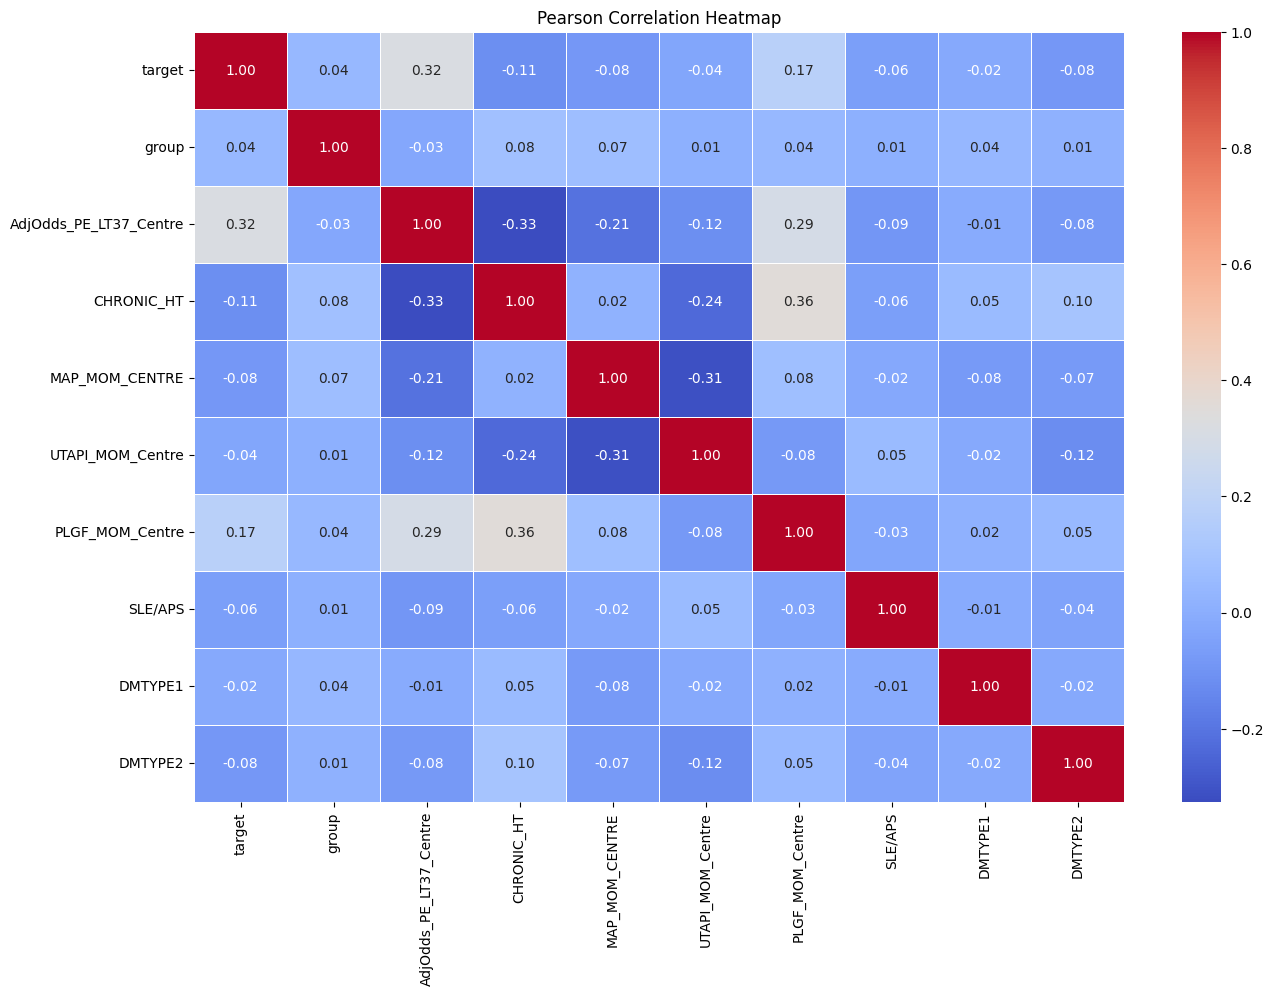

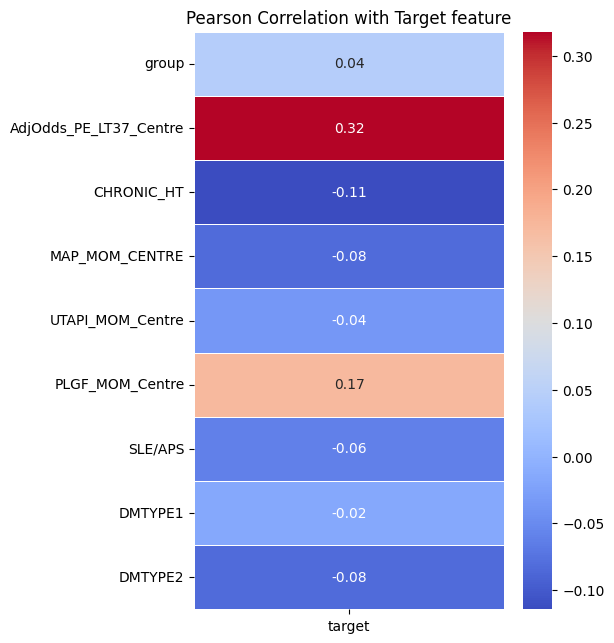

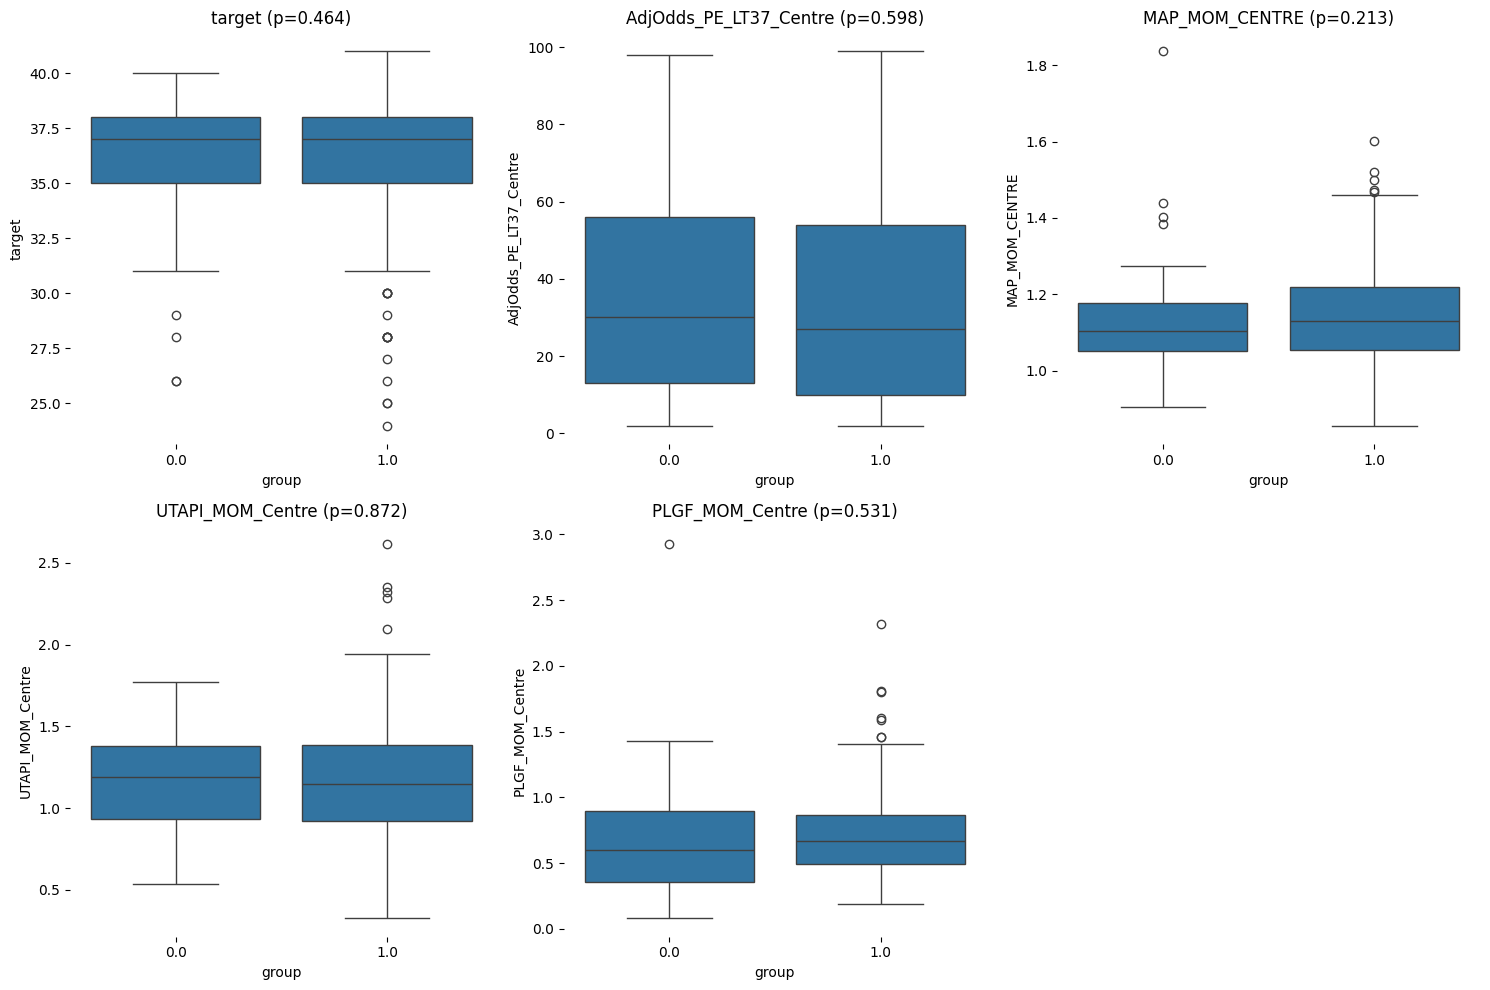

Best hyperparameters: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Model Evaluation:
Mean error: 0.004220722769022023
Mean absolute error: 1.8782252784233429
Mean squared error: 6.893663363776737
R2: 0.12257096222846683
___________________________
Metrics:
Mean error: -0.30815645782558976
Mean absolute error: 2.4619102523467236
Mean squared error: 11.466969977931024
___________________________
Statistics:
T-test: t-statistic = -0.7253, p-value = 0.4709
95% Confidence Interval: (-1.157176286268104, 0.5408633706169245)
___________________________


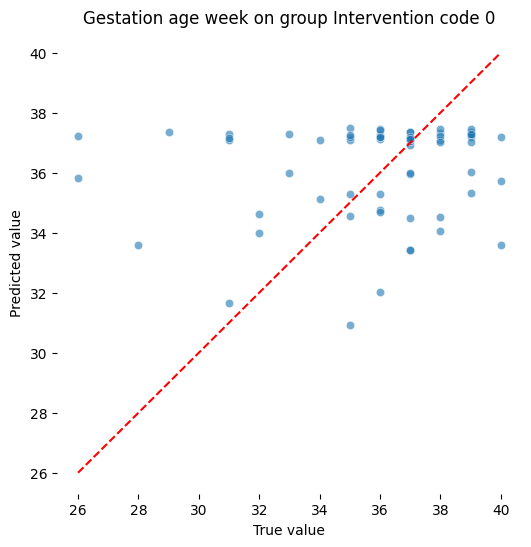

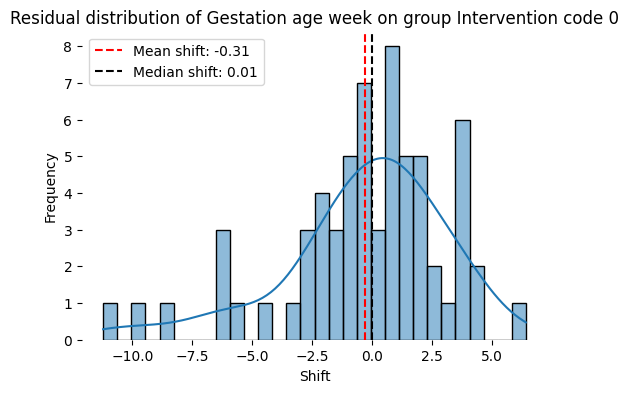

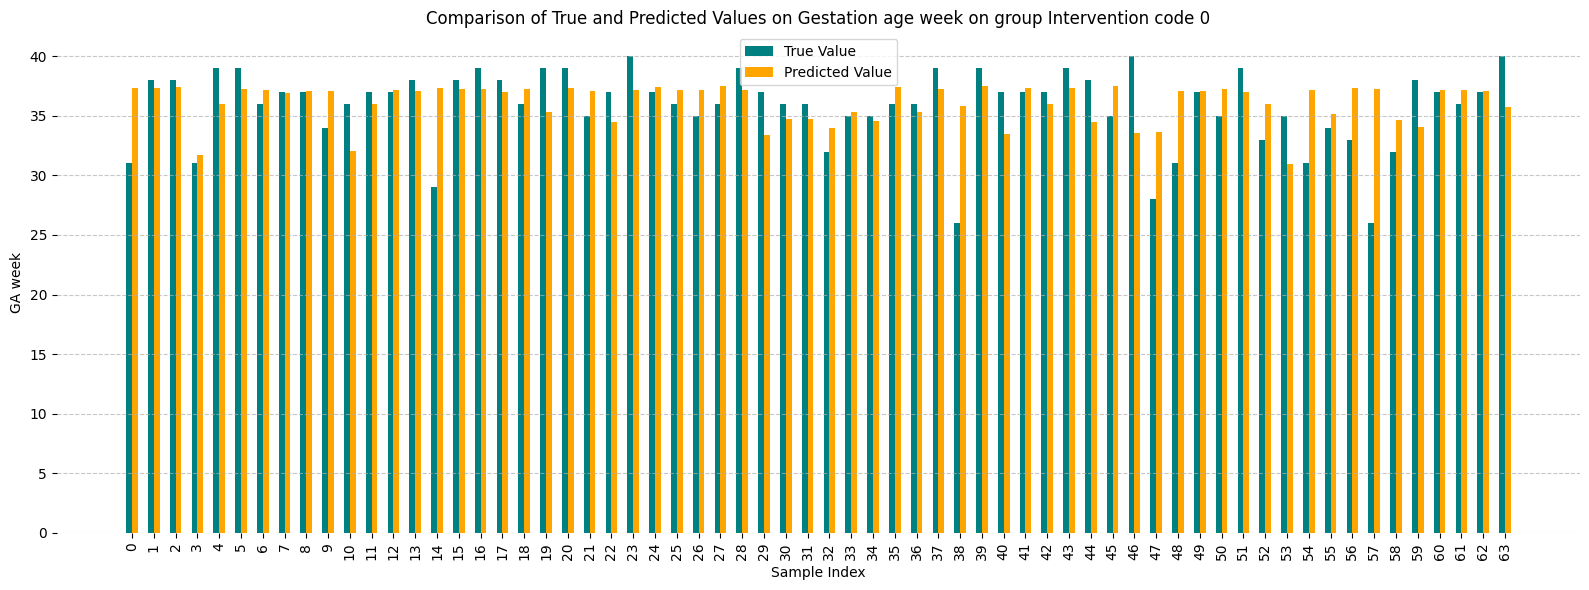

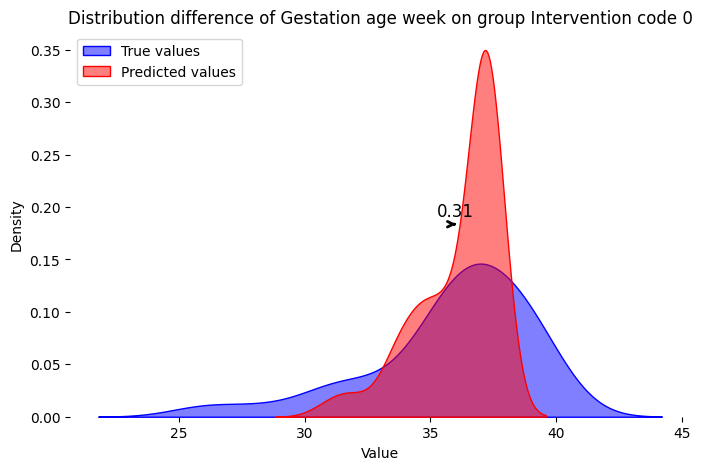

Number of samples in < 37 weeks: 31
___________________________
Metrics:
Mean error: -2.4384029031453434
Mean absolute error: 3.195963907126368
Mean squared error: 17.888129843267844
___________________________
Statistics:
T-test: t-statistic = -3.8648, p-value = 0.0006
95% Confidence Interval: (-3.7269414803620373, -1.1498643259286492)
___________________________


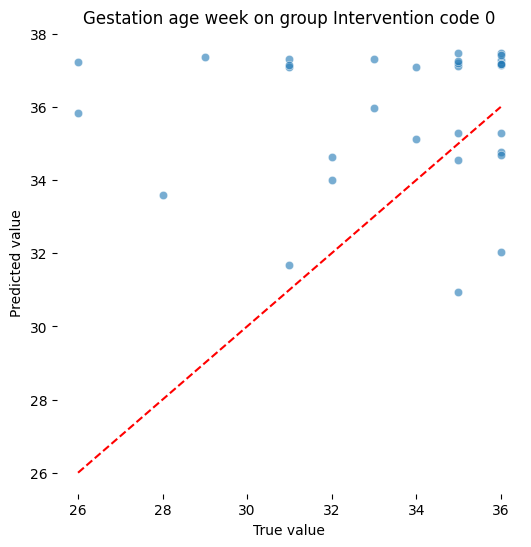

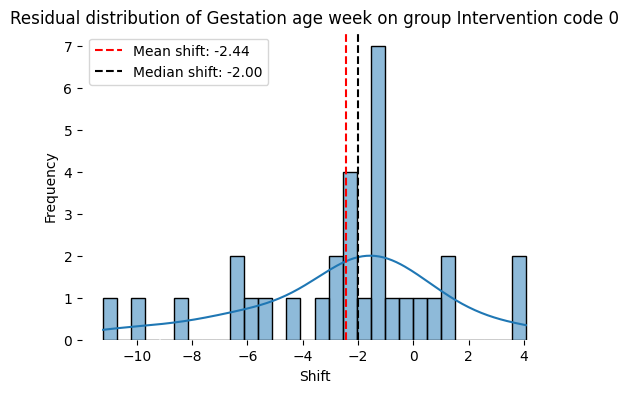

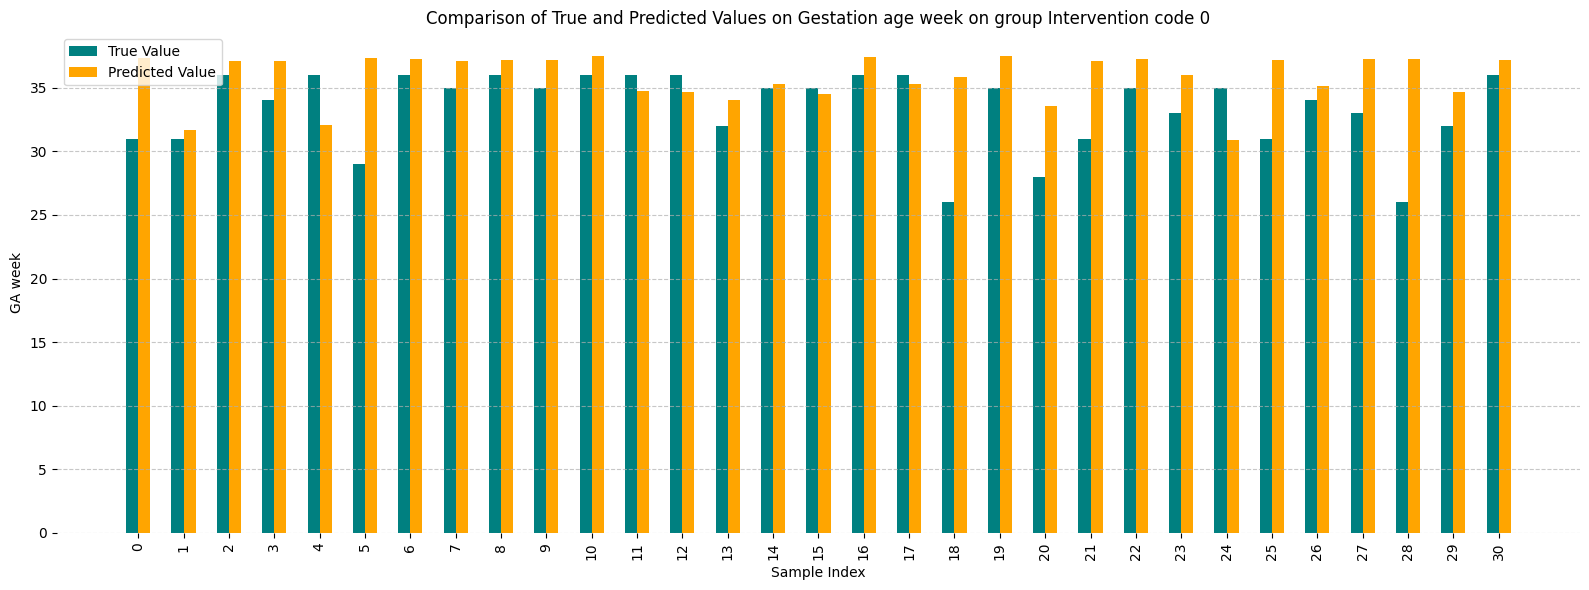

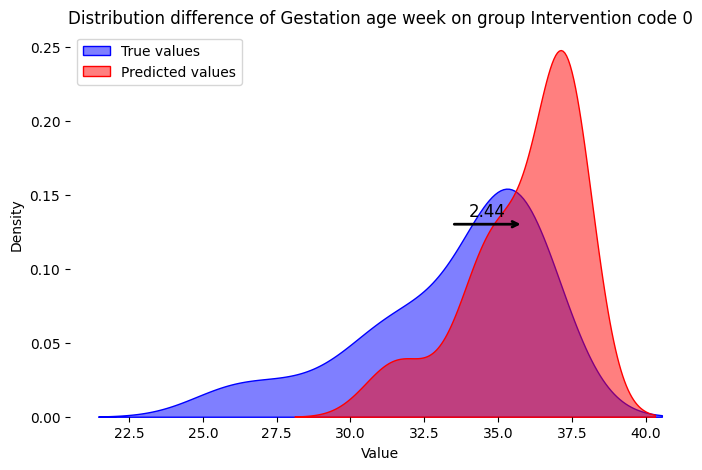

___________________________ 
 

STUDYPHASE CODE, GAWEEK


,target,group,AdjOdds_PE_LT37_Centre,CHRONIC_HT,MAP_MOM_CENTRE,UTAPI_MOM_Centre,PLGF_MOM_Centre,SLE/APS,DMTYPE1,DMTYPE2
0,36,2,7,0,1.1650,1.1135,0.2163,0,0,0
1,33,2,45,1,1.2844,1.0061,3.1460,0,0,0
2,36,2,2,1,1.3369,0.9543,0.4072,0,0,0
3,35,2,127,0,0.9049,1.3930,0.1188,0,0,0
4,36,2,24,0,1.2384,0.9861,0.4393,0,0,0
...,...,...,...,...,...,...,...,...,...,...
851,38,3,5,1,1.1765,1.6995,1.0392,0,0,0
852,37,3,50,0,1.1313,1.1157,0.9588,0,0,0
853,36,3,26,1,1.1454,0.7024,1.4084,0,0,0
854,37,3,56,0,1.0623,1.3515,1.0526,0,0,0


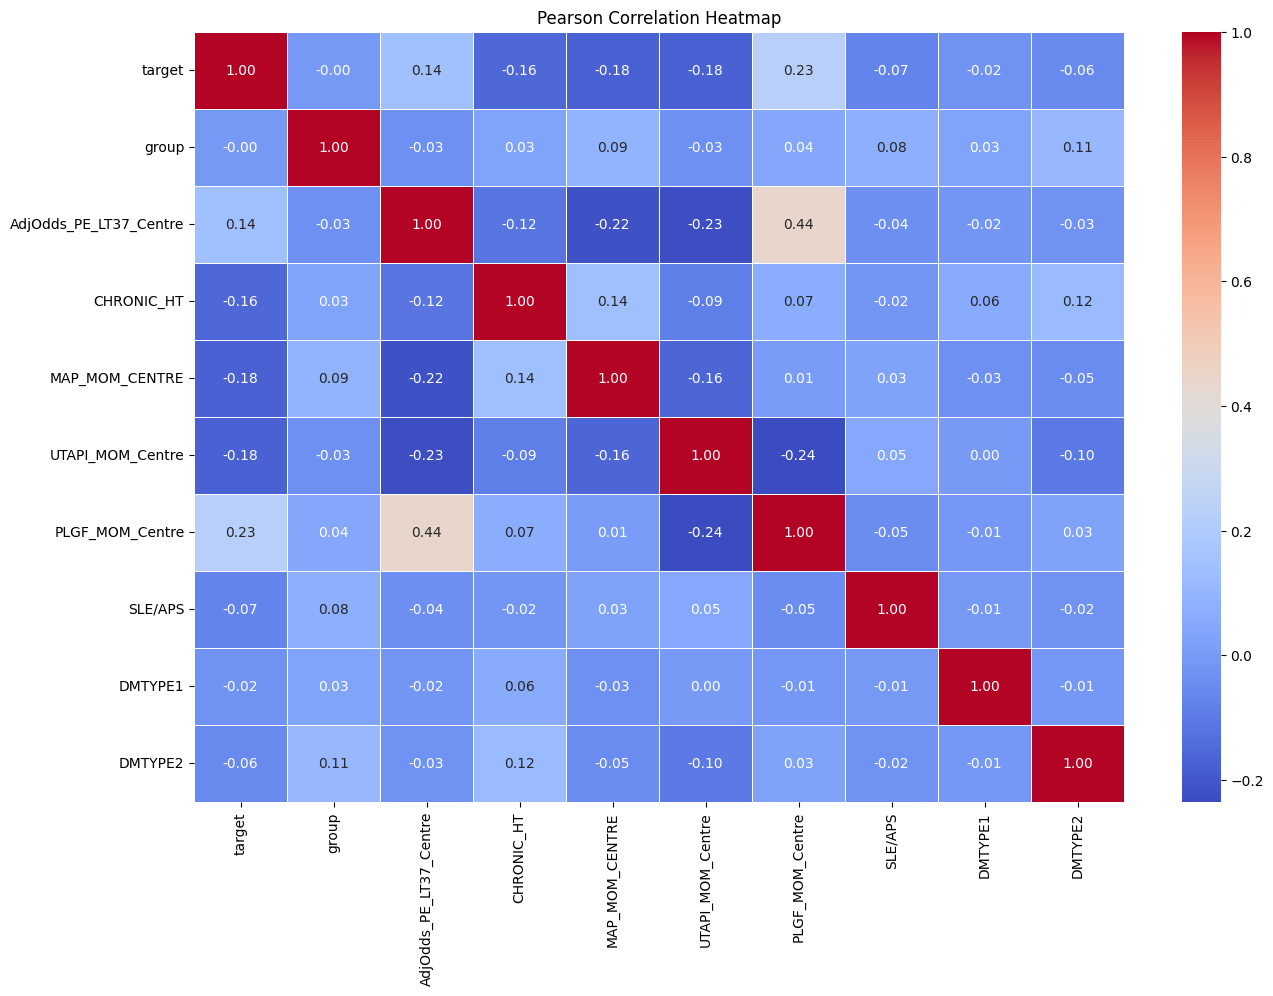

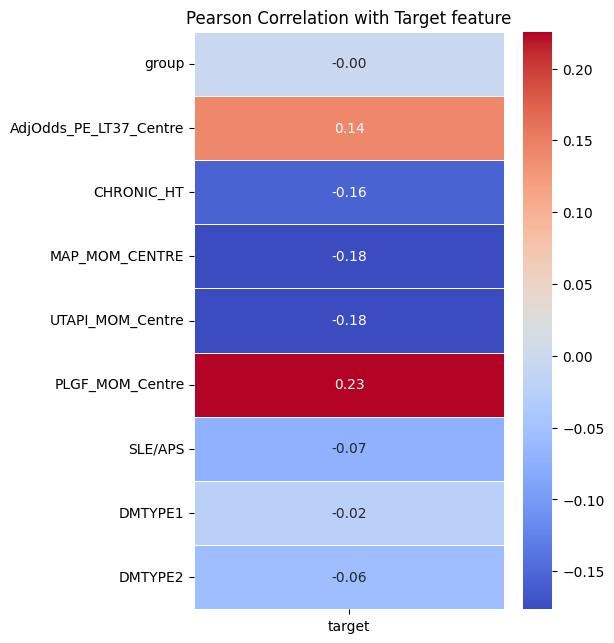

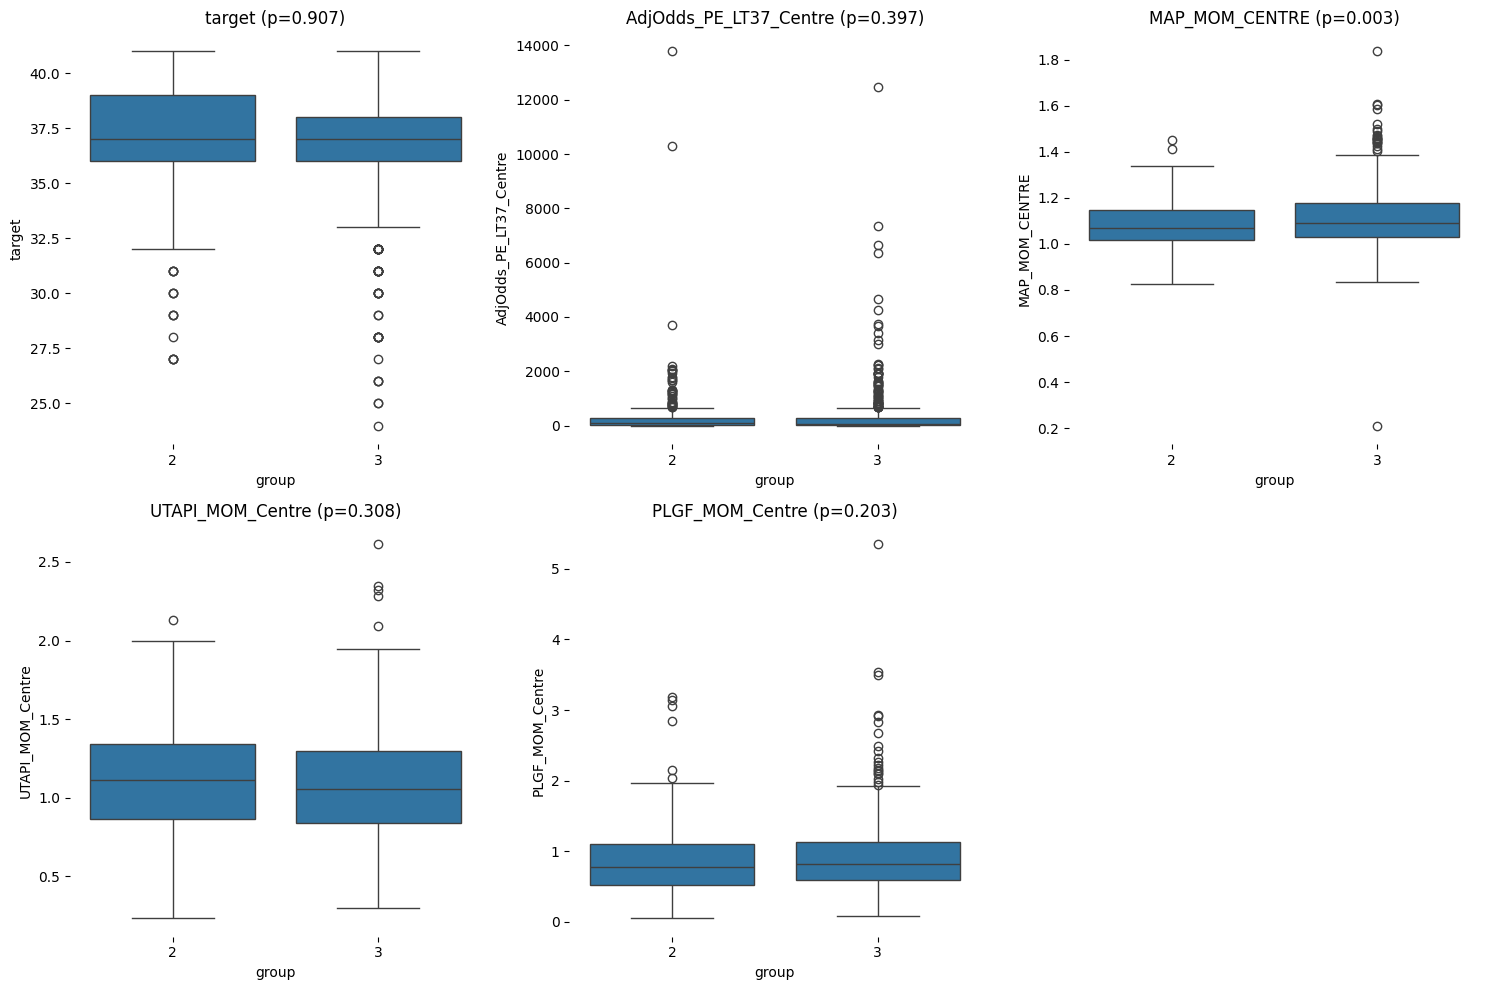

Best hyperparameters: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Model Evaluation:
Mean error: 0.05904551943116335
Mean absolute error: 1.8167140850361523
Mean squared error: 6.095854547555823
R2: 0.15828522704177792
___________________________
Metrics:
Mean error: -0.165630451266983
Mean absolute error: 1.7204179462821545
Mean squared error: 5.959673498693146
___________________________
Statistics:
T-test: t-statistic = -1.6823, p-value = 0.0930
95% Confidence Interval: (-0.3589792472558842, 0.027718344721918198)
___________________________


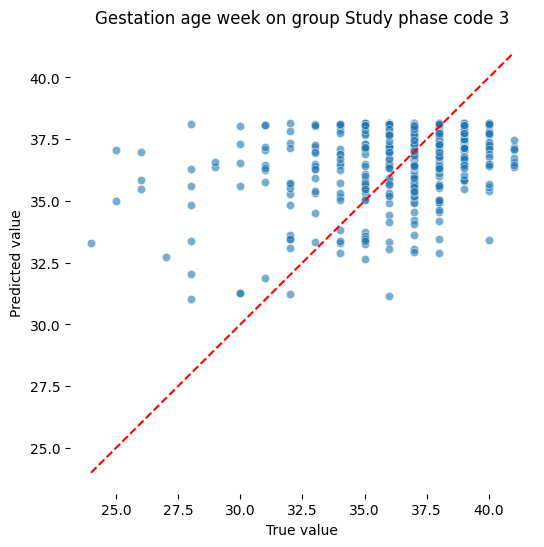

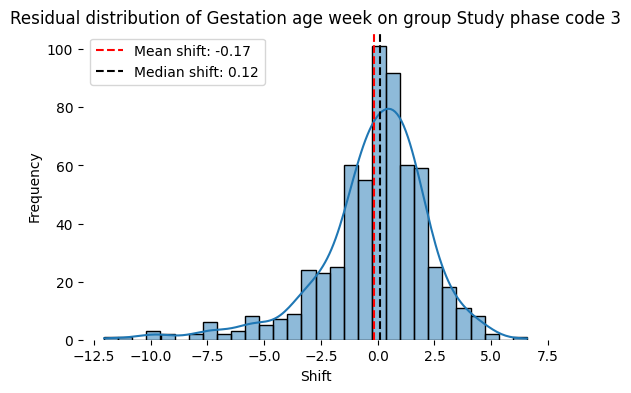

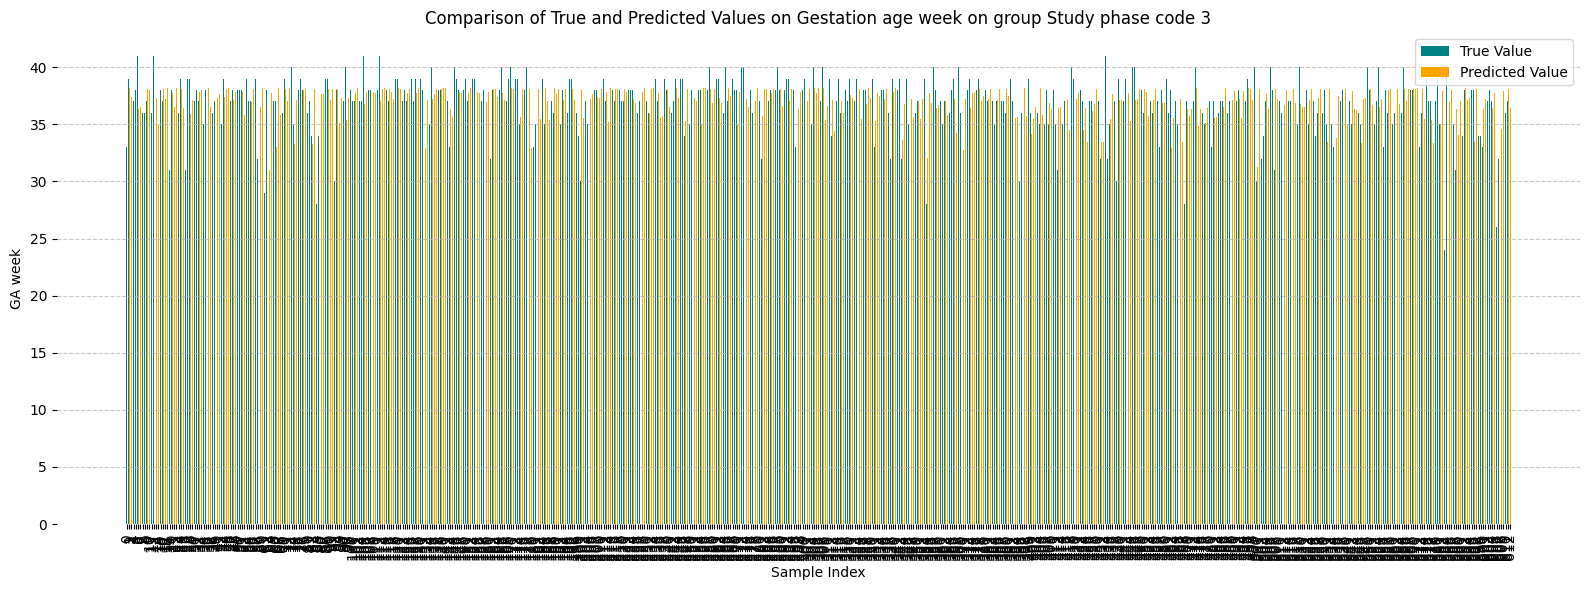

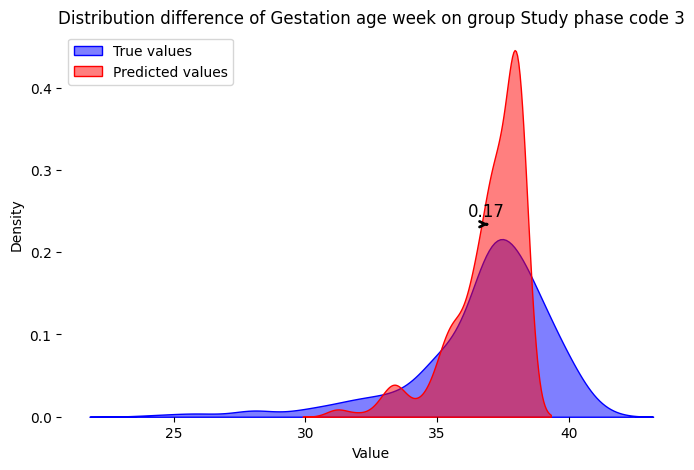

Number of samples in < 37 weeks: 191
___________________________
Metrics:
Mean error: -2.480321427266934
Mean absolute error: 2.841690699239199
Mean squared error: 13.437775789118612
___________________________
Statistics:
T-test: t-statistic = -12.6662, p-value = 0.0000
95% Confidence Interval: (-2.866585650769142, -2.094057203764726)
___________________________


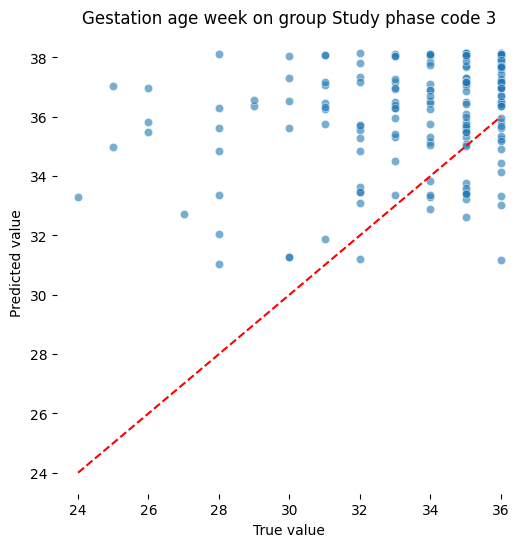

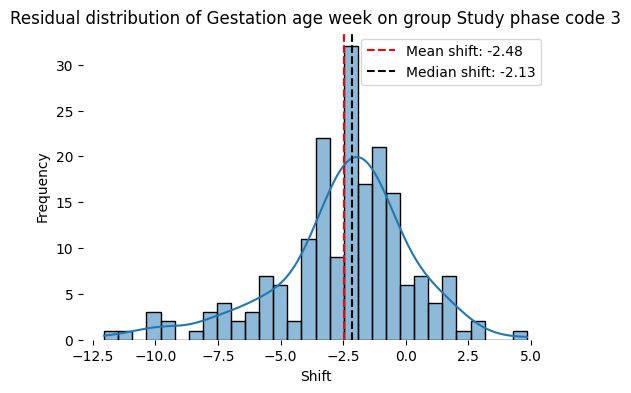

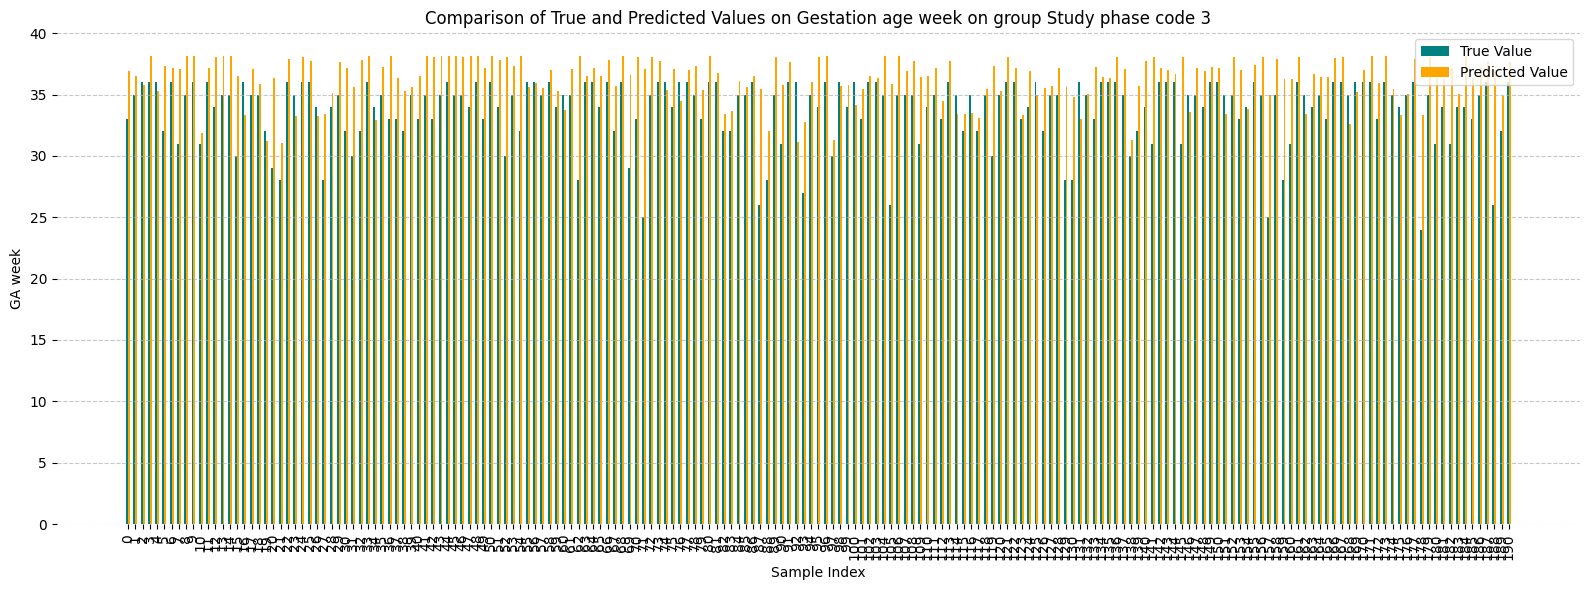

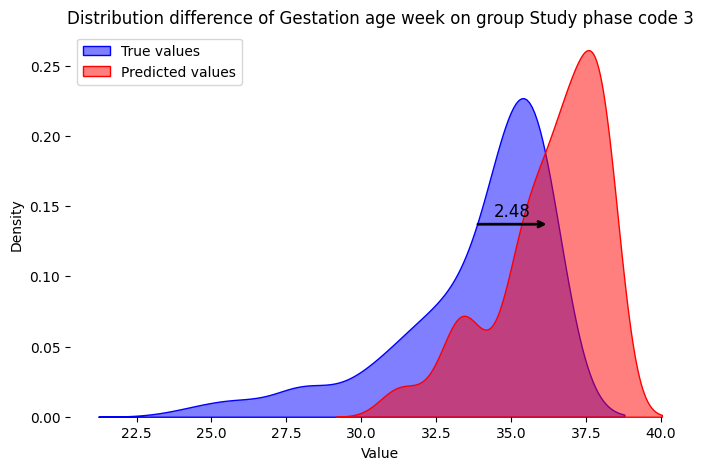

___________________________ 
 

INTERVENTION CODE, ONSET PE WEEK


,target,group,AdjOdds_PE_LT37_Centre,CHRONIC_HT,MAP_MOM_CENTRE,UTAPI_MOM_Centre,PLGF_MOM_Centre,SLE/APS,DMTYPE1,DMTYPE2
52,37.0,0.0,24,0,1.1829,1.4695,0.9438,0,0,0
53,35.0,1.0,42,0,1.3643,1.3888,0.7335,0,0,0
58,38.0,1.0,33,0,1.1678,1.3035,0.7973,0,0,0
59,37.0,1.0,48,0,1.4569,0.7580,1.0361,0,0,0
60,37.0,1.0,47,0,1.0362,1.2540,0.8648,0,0,0
...,...,...,...,...,...,...,...,...,...,...
843,31.0,0.0,45,0,1.0819,0.9210,0.3380,0,0,0
846,34.0,1.0,18,1,1.1294,0.7480,0.9730,0,0,0
847,37.0,1.0,26,0,1.0305,0.6760,0.3650,0,0,0
853,30.0,0.0,26,1,1.1454,0.7024,1.4084,0,0,0


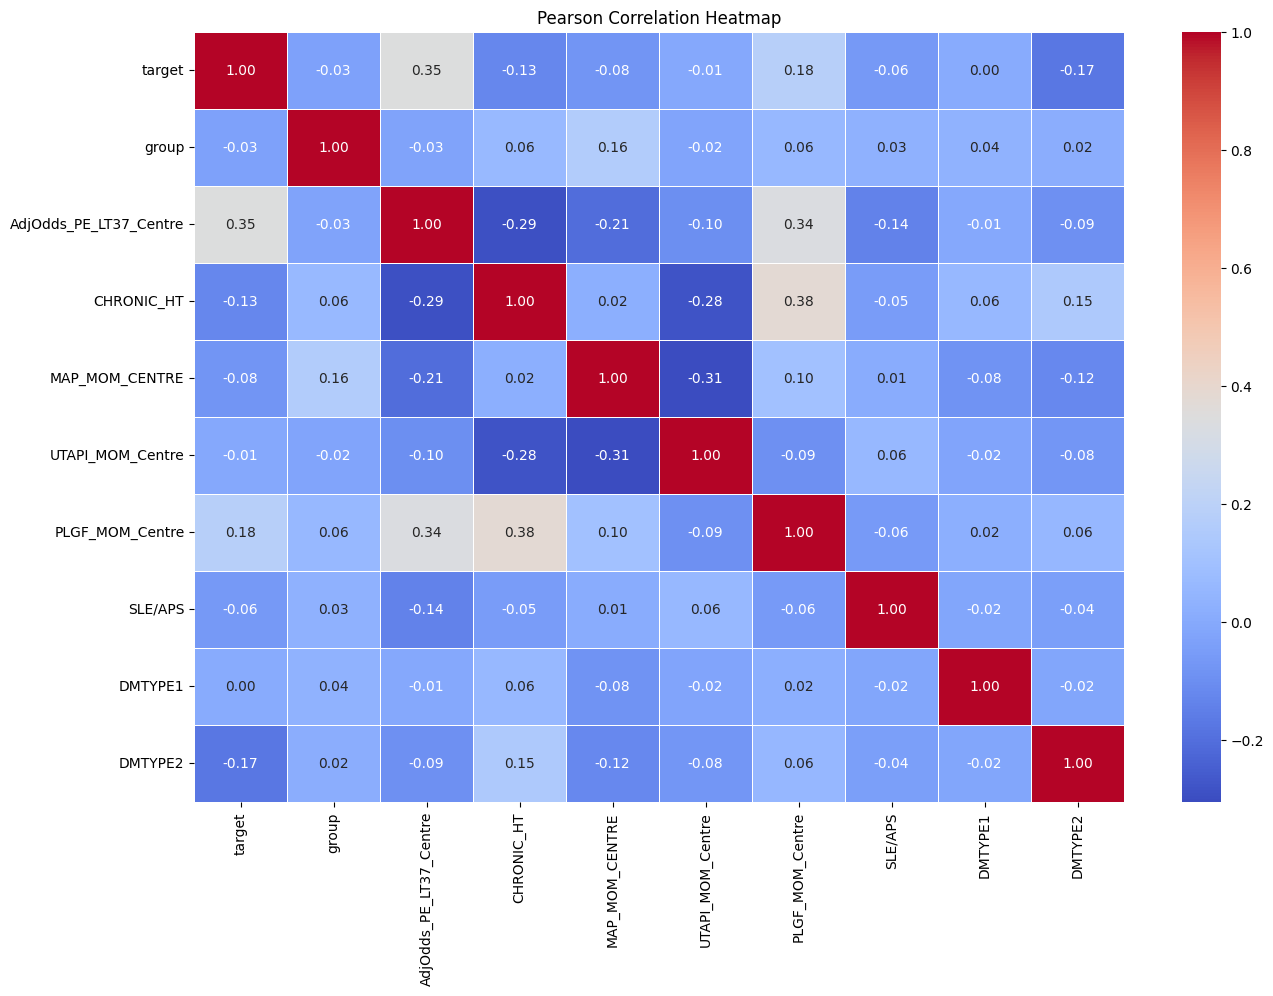

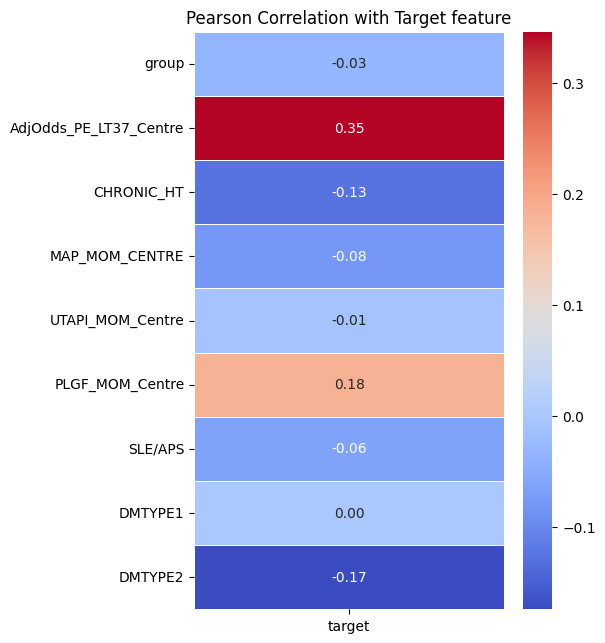

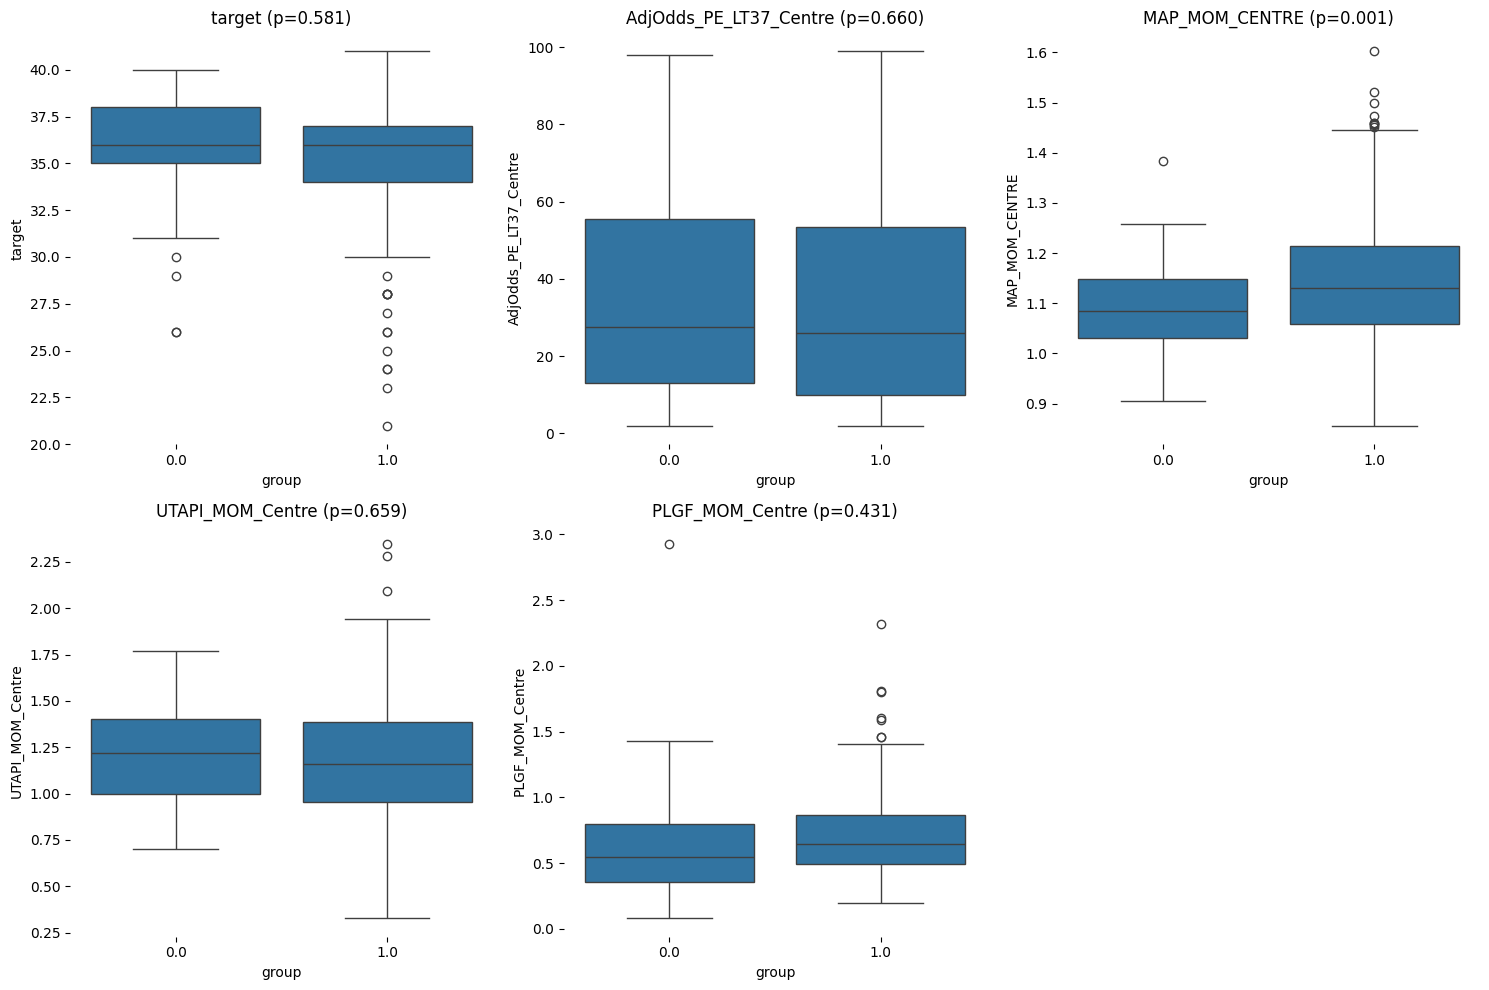

Best hyperparameters: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Model Evaluation:
Mean error: -5.6336583330907074e-05
Mean absolute error: 2.272246213276362
Mean squared error: 9.25843070497125
R2: 0.13823512072160227
___________________________
Metrics:
Mean error: 0.3099114914153564
Mean absolute error: 2.7920146631604803
Mean squared error: 12.994745014463728
___________________________
Statistics:
T-test: t-statistic = 0.5789, p-value = 0.5656
95% Confidence Interval: (-0.7684105247347794, 1.3882335075654924)
___________________________


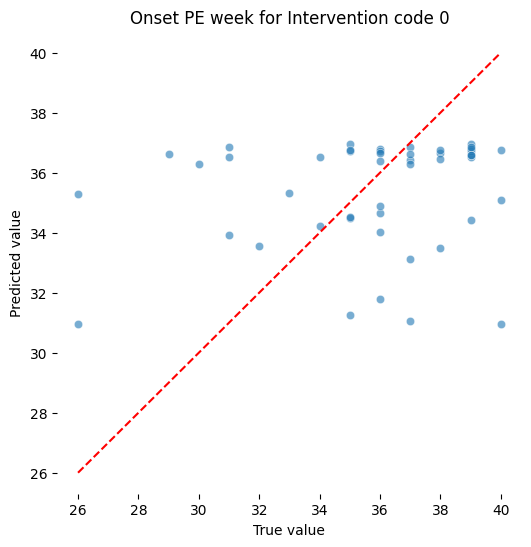

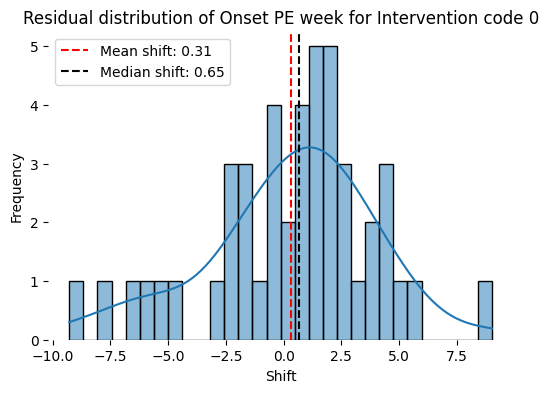

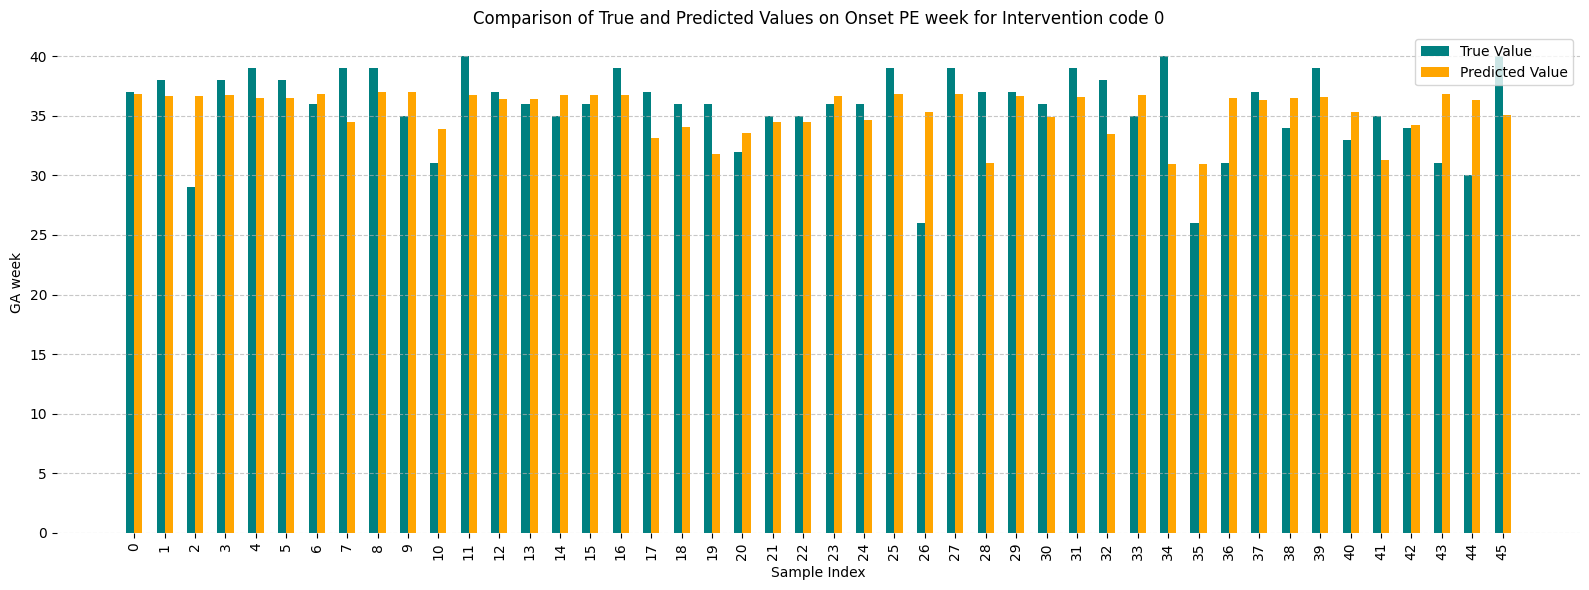

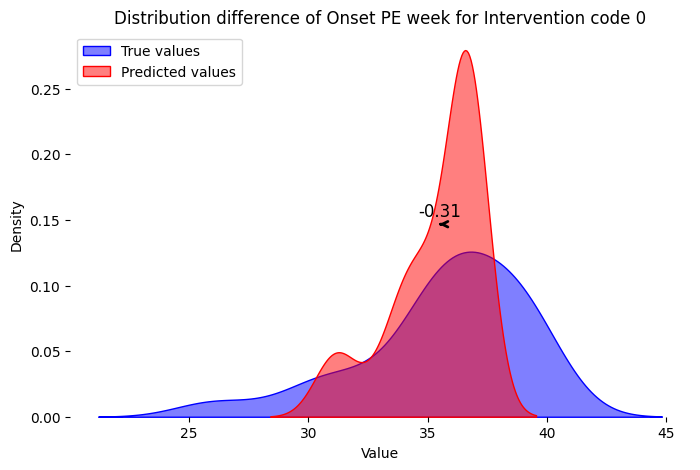

Number of samples in < 37 weeks: 25
___________________________
Metrics:
Mean error: -1.7488129594052413
Mean absolute error: 2.8182568766057865
Mean squared error: 13.8714218132711
___________________________
Statistics:
T-test: t-statistic = -2.6054, p-value = 0.0155
95% Confidence Interval: (-3.134156027965096, -0.3634698908453866)
___________________________


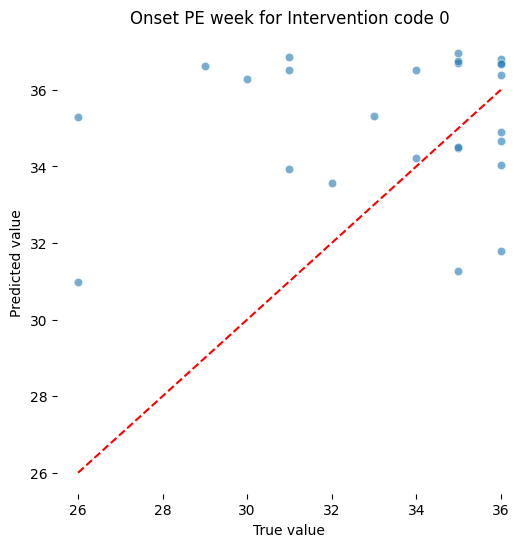

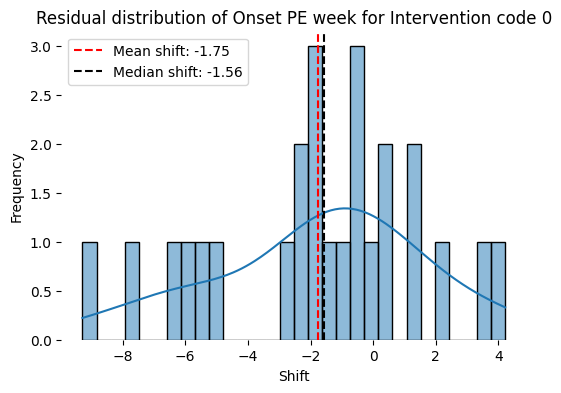

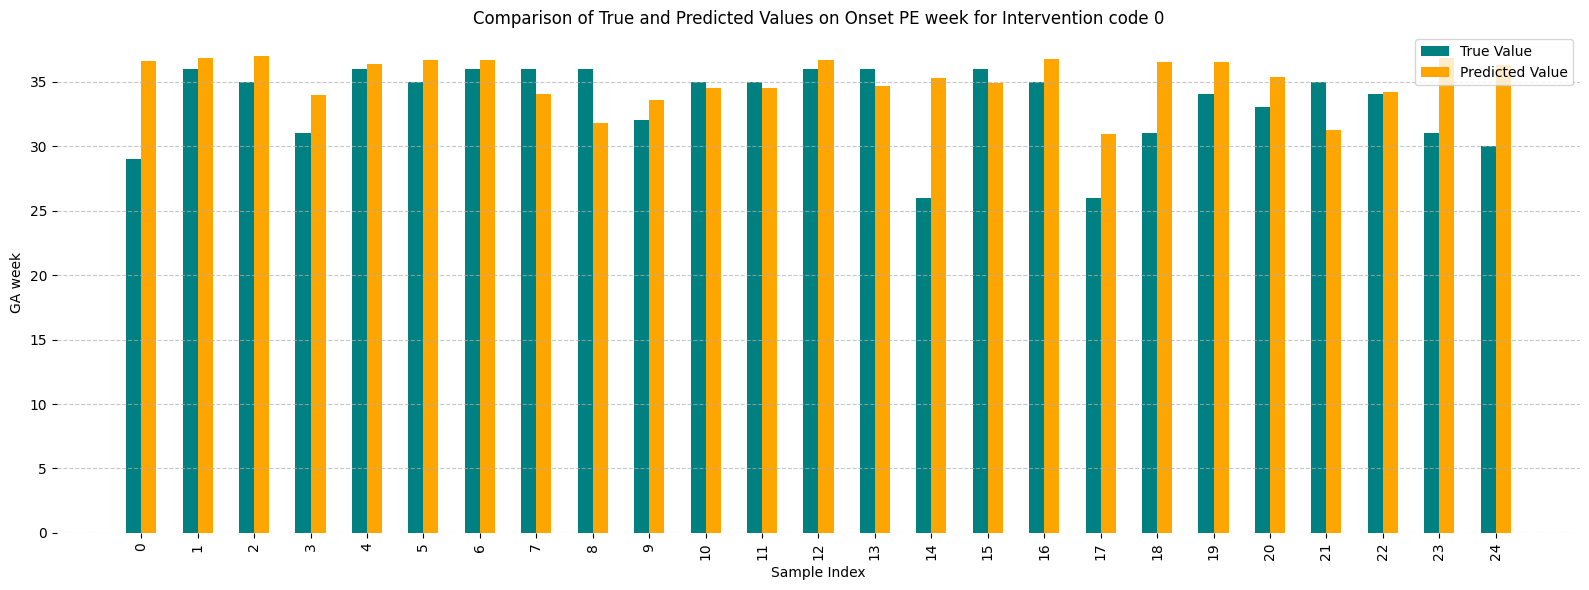

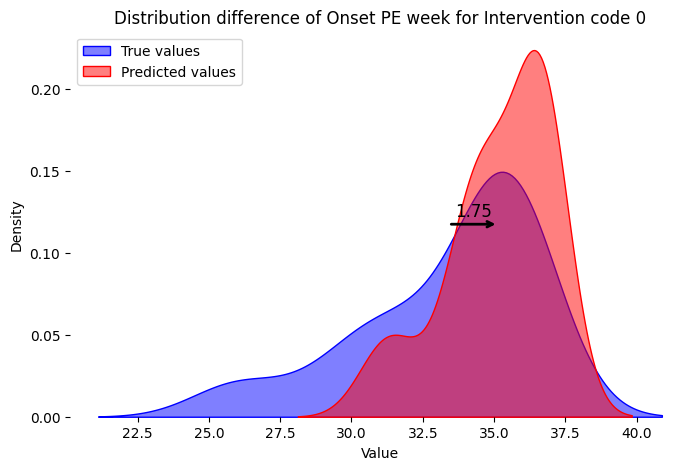

In [6]:
for c in configurations:
    
    print(separator, '\n', '\n')
    print(c['title'])
    
    df = c['df'][columns_of_interest]
    groups = c['groups']
    results_dir = c['results_dir']
    plot_title = c['plot_title']
    
    display(df)
    
    plot_stats(df, groups, results_dir)
    
    # Prepare train and test datasets
    X = df[df['group'] == groups[0]][columns_of_interest]
    test_group = df[df['group'] == groups[1]][columns_of_interest]
    test_group.drop(['group'], axis=1, inplace=True)
    y = X['target']
    X.drop(['target', 'group'], axis=1, inplace=True)

    # Run Grid Search for best hyperparameters 
    scores, best_params = get_best_params_reg(model, params, X, y)

    print(f'Best hyperparameters: {best_params}')
    print('Model Evaluation:')
    print_scores(scores)
    print(separator)

    # Fit model with best params on whole dataset
    model.set_params(**best_params)
    model.fit(X, y)

    # Test on other group
    X_test_group = test_group.drop(['target'], axis=1)
    y_test_group = test_group['target']

    y_pred_test_group = model.predict(X_test_group)
    calculate_shift(y_test_group, y_pred_test_group, results_dir, title='entire', plot_title=plot_title)
    
    # Test only on subset where target (weeks) < 37
    test_group_subset = test_group[test_group['target'] < 37]
    print(f'Number of samples in < 37 weeks: {test_group_subset.shape[0]}')
    print(separator)

    X_test_group_subset = test_group_subset.drop(['target'], axis=1)
    y_test_group_subset = test_group_subset['target']

    y_pred_subset = model.predict(X_test_group_subset)
    calculate_shift(y_test_group_subset, y_pred_subset, results_dir, title='subset', plot_title=plot_title)
    